<a href="https://colab.research.google.com/github/SayyedAliT/Artificial-Intelligence-Course-/blob/main/Project1/Project1_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.datasets import cifar10
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

# Load and show the dataset's images

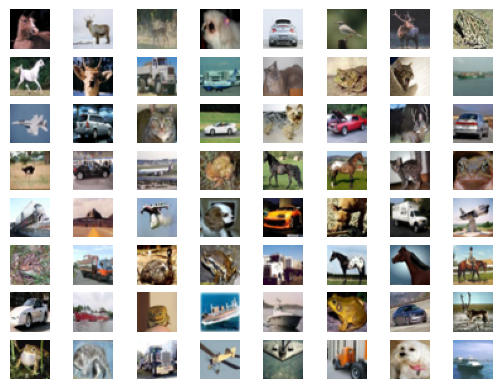

In [ ]:
(train_images, train_labels), (_, _) = cifar10.load_data()

import random
import matplotlib.pyplot as plt
for i in range(64):
    random_pic_index = random.randint(0, 50000)
    plt.subplot(8, 8, i + 1)
    plt.axis("off")
    plt.imshow(train_images[random_pic_index])
plt.show()

# Define the Dicriminator function:

In [ ]:
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define the Generator

In [ ]:
def define_generator(latent_dim):
    model = Sequential()

    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model


# Define gan with connecting the functions together

In [ ]:
def define_gan(g_model, d_model):

    d_model.trainable = False

    model = Sequential()

    model.add(g_model)

    model.add(d_model)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model



# defining the real smaple function and choosing and labeling real image to give them to discriminator

In [ ]:
def load_real_samples():

    (trainX, _), (_, _) = load_data()

    X = trainX.astype('float32')

    X = (X - 127.5) / 127.5
    return X


# select real samples
def generate_real_samples(dataset, n_samples):

    ix = randint(0, dataset.shape[0], n_samples)

    X = dataset[ix]

    y = ones((n_samples, 1))
    return X, y


# define the fake image creator and latent space creator


In [ ]:
def generate_latent_points(latent_dim, n_samples):

    x_input = randn(latent_dim * n_samples)

    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):

    x_input = generate_latent_points(latent_dim, n_samples)

    X = g_model.predict(x_input)

    y = zeros((n_samples, 1))
    return X, y


# saving the Plots for showing in the result.


In [ ]:
def save_plot(examples, epoch, n=7):

    examples = (examples + 1) / 2.0

    for i in range(n * n):

        pyplot.subplot(n, n, 1 + i)

        pyplot.axis('off')

        pyplot.imshow(examples[i])

    pyplot.show()


In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    X_real, y_real = generate_real_samples(dataset, n_samples)

    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))

    save_plot(x_fake, epoch)

    filename = 'generator_model.h5'
    g_model.save(filename)


# **Define the training process for the GAN and train the model**

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):

        for j in range(bat_per_epo):

            X_real, y_real = generate_real_samples(dataset, half_batch)

            d_loss1, _ = d_model.train_on_batch(X_real, y_real)

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

            X_gan = generate_latent_points(latent_dim, n_batch)

            y_gan = ones((n_batch, 1))

            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            if j % 100 == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))

        summarize_performance(i, g_model, d_model, dataset, latent_dim)


# training the data and see the result.


4/4 [==============================] - 0s 4ms/step
>1, 1/195, d1=0.699, d2=0.716 g=0.687
4/4 [==============================] - 0s 3ms/step
>1, 101/195, d1=0.375, d2=0.570 g=4.565
5/5 [==============================] - 0s 54ms/step
>Accuracy real: 67%, fake: 63%


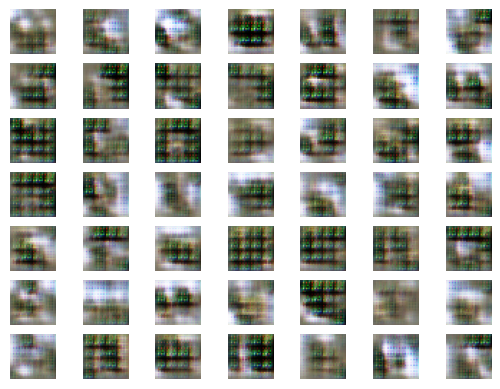

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 6ms/step
>2, 1/195, d1=0.535, d2=0.977 g=1.929
4/4 [==============================] - 0s 3ms/step
>2, 101/195, d1=0.422, d2=0.635 g=1.276
5/5 [==============================] - 0s 5ms/step
>Accuracy real: 82%, fake: 82%


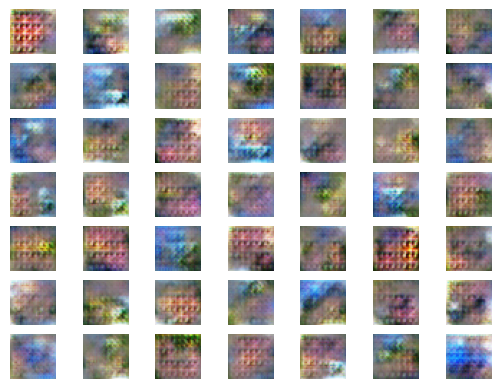

4/4 [==============================] - 0s 3ms/step
>3, 1/195, d1=0.384, d2=0.620 g=1.197
4/4 [==============================] - 0s 3ms/step
>3, 101/195, d1=0.501, d2=0.656 g=1.292
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 52%, fake: 97%


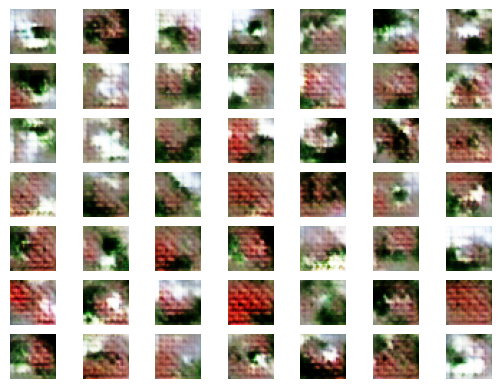

4/4 [==============================] - 0s 4ms/step
>4, 1/195, d1=0.656, d2=0.540 g=1.603
4/4 [==============================] - 0s 3ms/step
>4, 101/195, d1=0.649, d2=0.688 g=1.282
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 50%, fake: 62%


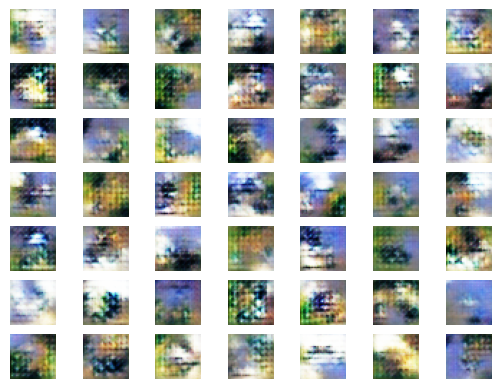

4/4 [==============================] - 0s 4ms/step
>5, 1/195, d1=0.744, d2=0.799 g=1.197
4/4 [==============================] - 0s 3ms/step
>5, 101/195, d1=0.703, d2=0.535 g=1.760
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 61%, fake: 65%


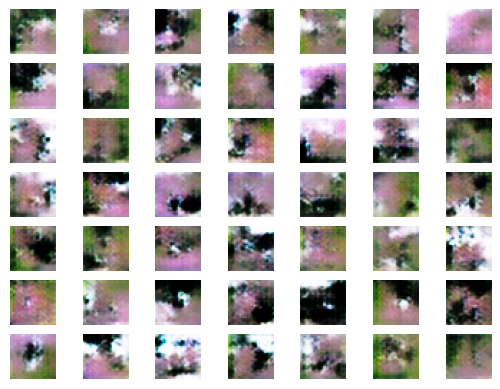

4/4 [==============================] - 0s 3ms/step
>6, 1/195, d1=0.662, d2=0.623 g=1.309
4/4 [==============================] - 0s 3ms/step
>6, 101/195, d1=0.679, d2=0.643 g=1.177
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 68%, fake: 73%


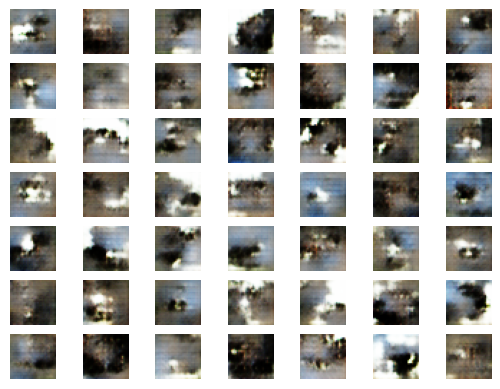

4/4 [==============================] - 0s 3ms/step
>7, 1/195, d1=0.664, d2=0.670 g=1.270
4/4 [==============================] - 0s 3ms/step
>7, 101/195, d1=0.556, d2=0.686 g=1.204
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 67%, fake: 67%


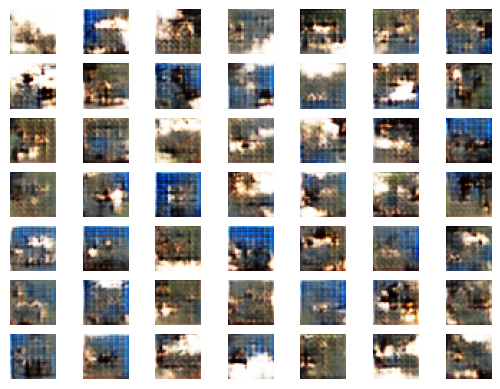

4/4 [==============================] - 0s 6ms/step
>8, 1/195, d1=0.624, d2=0.631 g=1.791
4/4 [==============================] - 0s 4ms/step
>8, 101/195, d1=0.512, d2=0.704 g=1.667
5/5 [==============================] - 0s 5ms/step
>Accuracy real: 57%, fake: 84%


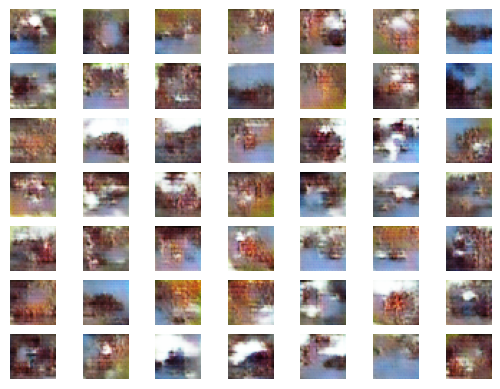

4/4 [==============================] - 0s 6ms/step
>9, 1/195, d1=0.691, d2=0.572 g=1.360
4/4 [==============================] - 0s 3ms/step
>9, 101/195, d1=0.642, d2=0.559 g=1.367
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 65%, fake: 74%


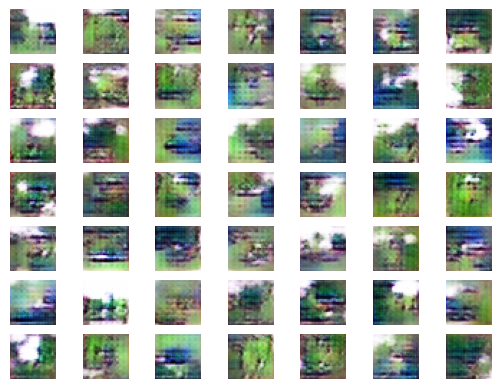

4/4 [==============================] - 0s 7ms/step
>10, 1/195, d1=0.562, d2=0.528 g=1.497
4/4 [==============================] - 0s 5ms/step
>10, 101/195, d1=0.630, d2=0.819 g=1.203
5/5 [==============================] - 0s 4ms/step
>Accuracy real: 56%, fake: 71%


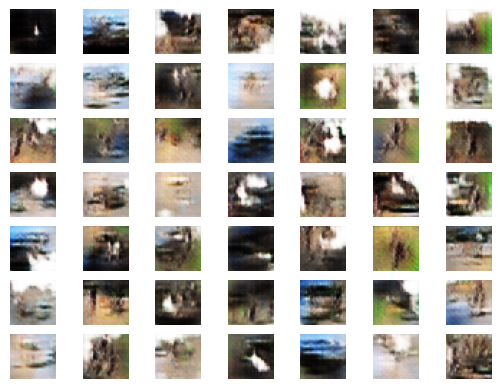

4/4 [==============================] - 0s 3ms/step
>11, 1/195, d1=0.598, d2=0.638 g=1.234
4/4 [==============================] - 0s 3ms/step
>11, 101/195, d1=0.706, d2=0.617 g=1.247
5/5 [==============================] - 0s 4ms/step
>Accuracy real: 63%, fake: 83%


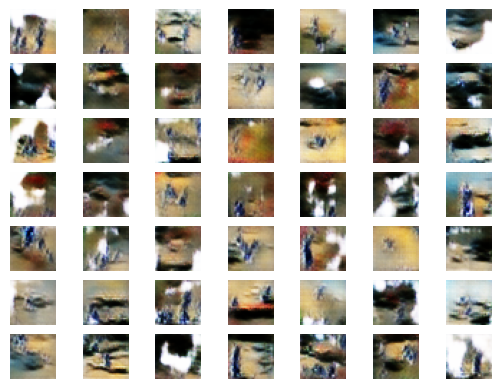

4/4 [==============================] - 0s 5ms/step
>12, 1/195, d1=0.655, d2=0.612 g=1.085
4/4 [==============================] - 0s 4ms/step
>12, 101/195, d1=0.642, d2=0.596 g=1.049
5/5 [==============================] - 0s 5ms/step
>Accuracy real: 46%, fake: 75%


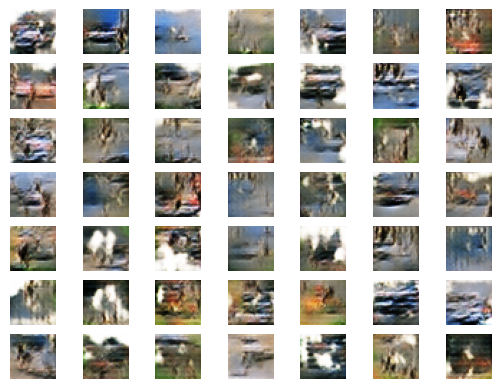

4/4 [==============================] - 0s 3ms/step
>13, 1/195, d1=0.725, d2=0.637 g=1.110
4/4 [==============================] - 0s 4ms/step
>13, 101/195, d1=0.667, d2=0.693 g=0.990
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 53%, fake: 76%


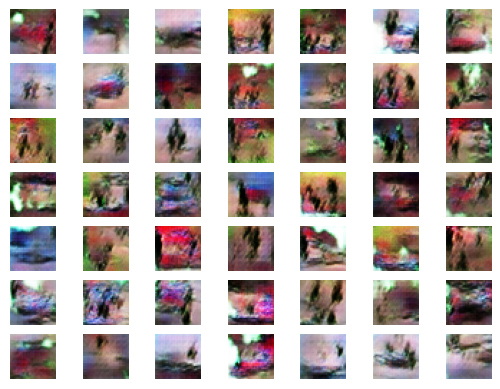

4/4 [==============================] - 0s 3ms/step
>14, 1/195, d1=0.606, d2=0.652 g=1.116
4/4 [==============================] - 0s 3ms/step
>14, 101/195, d1=0.656, d2=0.690 g=0.982
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 59%, fake: 80%


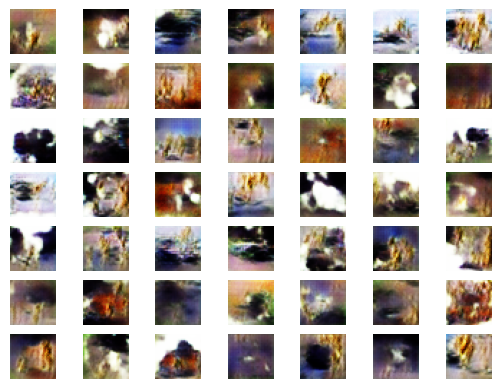

4/4 [==============================] - 0s 6ms/step
>15, 1/195, d1=0.654, d2=0.630 g=1.061
4/4 [==============================] - 0s 4ms/step
>15, 101/195, d1=0.649, d2=0.652 g=0.970
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 52%, fake: 84%


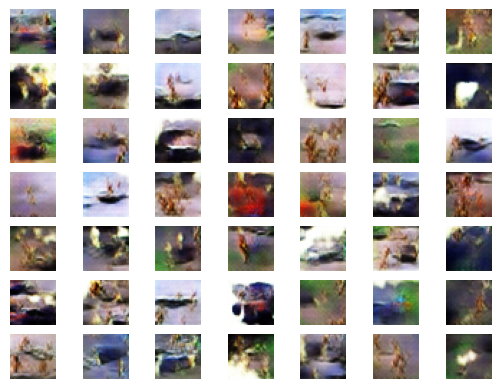

4/4 [==============================] - 0s 3ms/step
>16, 1/195, d1=0.649, d2=0.633 g=1.030
4/4 [==============================] - 0s 4ms/step
>16, 101/195, d1=0.593, d2=0.738 g=1.097
5/5 [==============================] - 0s 4ms/step
>Accuracy real: 53%, fake: 89%


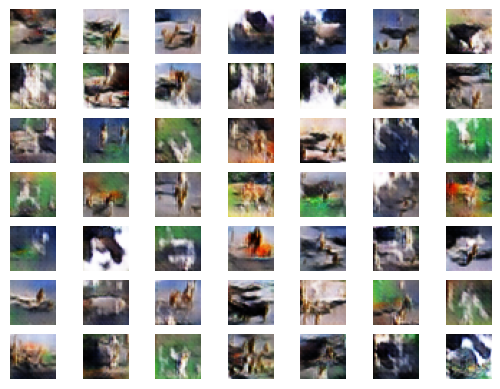

4/4 [==============================] - 0s 4ms/step
>17, 1/195, d1=0.643, d2=0.566 g=1.100
4/4 [==============================] - 0s 9ms/step
>17, 101/195, d1=0.175, d2=0.000 g=30.103
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 98%, fake: 100%


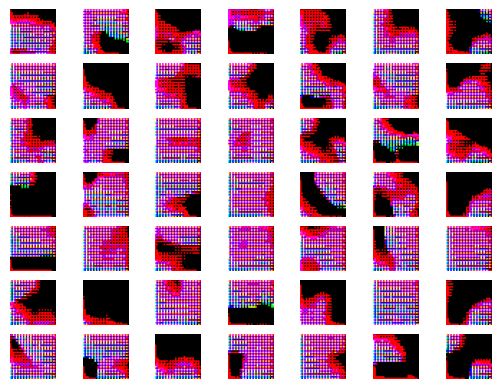

4/4 [==============================] - 0s 4ms/step
>18, 1/195, d1=0.129, d2=0.016 g=13.512
4/4 [==============================] - 0s 4ms/step
>18, 101/195, d1=0.069, d2=0.077 g=14.468
5/5 [==============================] - 0s 4ms/step
>Accuracy real: 99%, fake: 100%


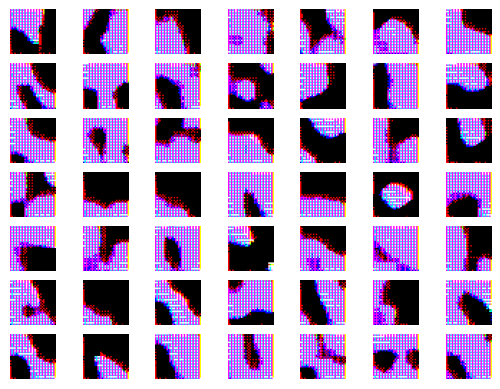

4/4 [==============================] - 0s 3ms/step
>19, 1/195, d1=0.002, d2=0.000 g=21.463
4/4 [==============================] - 0s 4ms/step
>19, 101/195, d1=0.002, d2=0.000 g=17.936
5/5 [==============================] - 0s 3ms/step
>Accuracy real: 100%, fake: 100%


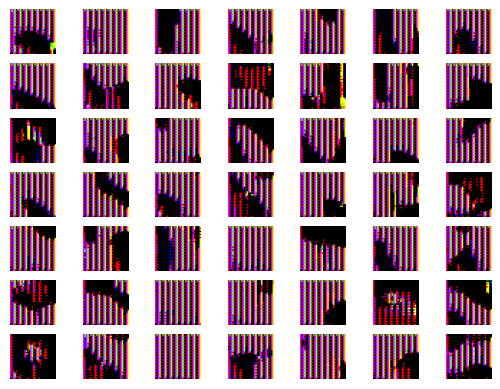

4/4 [==============================] - 0s 6ms/step
>20, 1/195, d1=0.000, d2=0.004 g=17.860
4/4 [==============================] - 0s 4ms/step
>20, 101/195, d1=0.030, d2=0.000 g=19.416
5/5 [==============================] - 0s 4ms/step
>Accuracy real: 100%, fake: 100%


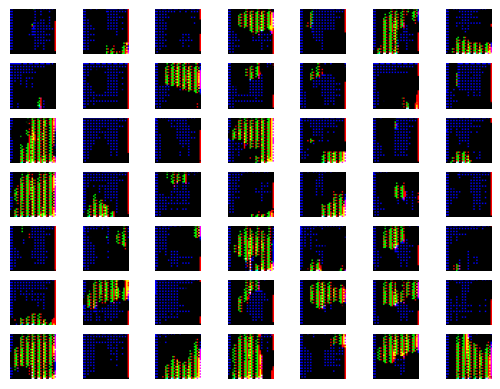

In [ ]:
latent_dim = 100

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim, 20, 256)

***Part 2*** - `Section B`



`Generative Adversarial Network (GAN): `

A GAN consists of a generator that produces synthetic samples realistic enough to deceive the discriminator.


`Generator’s Objective: `

The generator aims to maximize the probability that the discriminator classifies its outputs as real.


`Gradient Descent vs. Gradient Ascent: `

Gradient descent minimizes the generator’s objective function, while gradient ascent maximizes it.
Practitioners often use gradient ascent due to the nature of the generator’s goal.


`Generator’s Goal:`

 The generator’s goal is to “fool” the discriminator into classifying its outputs as real.

`Optimization Techniques:`

 The use of gradient ascent instead of gradient descent for optimizing the generator’s objective function in GANs makes it a more suitable optimization technique for this task.

# Part *III*




**`Part A)`**
When our dataset is small and different from the original dataset used to train the pre-trained model, we can employ Transfer Learning in the following way:

- Use the Pre-trained Model as a Feature Extractor:



- Fine-tune Some Layers of the Pre-trained Model:




**`Part B)`**

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split


# Load the pre-trained VGG16 model from keras applications

In [ ]:


pretrained_model_1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Unfreeze the layers

In [ ]:

for layer in pretrained_model_1.layers:
    layer.trainable = False

# Define our model

In [ ]:

model_1 = tf.keras.Sequential([
    pretrained_model_1,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


model_1.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


# Load and preprocces DataSet

In [ ]:
(train_dataset, validation_dataset) = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], shuffle_files=True, as_supervised=True)

def format_image(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label


train = train_dataset.take(200).map(format_image).shuffle(1024).batch(4)

validation = validation_dataset.map(format_image).batch(32)

# Fit the model

In [ ]:

history = model_1.fit(train, epochs=10, validation_data=validation)


58889256/58889256 [==============================] - 2s 0us/step


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incomplete2UV9CG/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Epoch 1/10
50/50 [==============================] - 48s 870ms/step - loss: 5.0375 - accuracy: 0.6450 - val_loss: 2.8453 - val_accuracy: 0.7440
Epoch 2/10
50/50 [==============================] - 21s 427ms/step - loss: 0.2113 - accuracy: 0.9700 - val_loss: 2.2937 - val_accuracy: 0.7887
Epoch 3/10
50/50 [==============================] - 23s 452ms/step - loss: 0.0791 - accuracy: 0.9950 - val_loss: 2.2897 - val_accuracy: 0.7837
Epoch 4/10
50/50 [==============================] - 23s 465ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.2448 - val_accuracy: 0.7893
Epoch 5/10
50/50 [==============================] - 23s 462ms/step - loss: 5.8289e-05 - accuracy: 1.0000 - val_loss: 2.2299 - val_accuracy: 0.7893
Epoch 6/10
50/50 [==============================] - 23s 449ms/step - loss: 4.7398e-05 - accuracy: 1.0000 - val_loss: 2.2284 - val_accuracy: 0.7896
E